<a href="https://colab.research.google.com/github/bernhardtandy/ProjectsMLAI/blob/main/HW2_AndyBernhardt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projects in Machine Learning and AI Homework 2**
## *Decision Trees, Bagging, and Boosting for Binary Music Genre Classification*
##### **Andy Bernhardt**
##### **bernha@rpi.edu**

---
## **Task 0: Load Libraries and Preprocess GTZAN Dataset**

In this section, we will load the required libraries and dataset (GTZAN) for the project, and preprocess the data.


### Setup

In [ ]:
# Import required libraries for project
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

### Load dataset from Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Add HW2 folder to path
import sys
sys.path.append('/content/drive/MyDrive/ProjectsMLAI/HW2')

In [ ]:
# Load GTZAN 3-second dataset
df = pd.read_csv("/content/drive/MyDrive/ProjectsMLAI/HW2/GTZAN.csv")

### Dataset description
GTZAN is the "most-used public dataset for evaluation in machine listening research for music genre recognition (MGR)". Most notably, it includes a dataset of 30-second audio clips from 100 audio files for 10 genres each, as well as an image for each audio file which is a "visual representation" of the file. In addition, the dataset includes two CSV files: one with features extracted from each 30-second audio file ($\approx$100 examples per genre/10 genres), and a second with features extracted from each audio file split into 3-second clips ($\approx$1000 examples per genre/10 genres). Although the data is from recordings collected in 2000-2001, the dataset is relatively new ($\approx$ two years old).

In this project, we use the second CSV file of features from 3-second clips, and consider only the data corresponding to the "classical" and "pop" genres (998 examples for "classical" and 1000 examples for "pop" - a balanced dataset) in order to project the general multi-class genre classification task into a binary classification task. We first split the dataset 80/20 into training and test sets, and then implement various models to predict the genre given the feature information. These models are finally evaluated on the held-out test set and compared.

Link to dataset: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

### Data Preprocessing
- Show dataset
- Filter rows with labels "classical" and "pop"
- Split dataframe into training (80%) and testing (20%) sets
- Isolate features (chroma_stft_mean, chroma_stft_var, rms_mean, rms_var, spectral_centroid_mean, spectral_centroid_var, spectral_bandwidth_mean, spectral_bandwidth_var, rolloff_mean, rolloff_var, zero_crossing_rate_mean, zero_crossing_rate_var, harmony_mean, harmony_var, perceptr_mean, perceptr_var, tempo, mfcc1_mean, mfcc1_var, mfcc2_mean, mfcc2_var, mfcc3_mean, mfcc3_var, mfcc4_mean, mfcc4_var, mfcc5_mean, mfcc5_var, mfcc6_mean, mfcc6_var, mfcc7_mean, mfcc7_var, mfcc8_mean, mfcc8_var, mfcc9_mean, mfcc9_var, mfcc10_mean, mfcc10_var, mfcc11_mean, mfcc11_var, mfcc12_mean, mfcc12_var, mfcc13_mean, mfcc13_var, mfcc14_meanm, fcc14_var, mfcc15_mean, mfcc15_var, mfcc16_mean, mfcc16_var, mfcc17_mean, mfcc17_var, mfcc18_mean, mfcc18_var, mfcc19_mean, mfcc19_var, mfcc20_mean, mfcc20_var)
- Normalize features
- Change labels to 0 ("classical") and 1 ("pop") and isolate labels

In [ ]:
# Show dataset
df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,rock.00099.5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,rock.00099.6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,rock.00099.7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,rock.00099.8.wav,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


In [ ]:
# Show original label value counts
print(f"Value counts:\n{df.label.value_counts()}")

Value counts:
blues        1000
jazz         1000
metal        1000
pop          1000
reggae       1000
disco         999
classical     998
hiphop        998
rock          998
country       997
Name: label, dtype: int64


In [ ]:
# Filter rows with labels "classical" and "pop"
df_filtered = df.loc[df['label'].isin(['classical', 'pop'])]
df_filtered

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
1000,classical.00000.0.wav,66149,0.255331,0.080393,0.032510,0.000075,1599.272683,1.856708e+04,1675.591596,20596.851729,...,55.257095,-1.666343,104.916260,4.525014,69.806412,-0.897889,110.099174,4.160629,194.109070,classical
1001,classical.00000.1.wav,66149,0.231431,0.084894,0.031453,0.000059,1551.352817,2.852497e+04,1485.790068,28831.794511,...,50.988071,-1.546098,65.954590,7.157280,69.336983,2.718532,120.725609,-1.692275,150.527496,classical
1002,classical.00000.2.wav,66149,0.225458,0.082233,0.041776,0.000222,1466.237496,4.501883e+04,1495.076539,10600.321072,...,81.254791,-4.686039,102.037117,-4.411082,60.409714,-2.694283,60.788319,3.038420,213.015579,classical
1003,classical.00000.3.wav,66149,0.260866,0.082233,0.032749,0.000136,1435.850575,3.227031e+04,1585.998216,36208.016702,...,40.191471,2.764065,46.115536,-0.732678,60.197281,-8.223904,64.066719,1.734897,119.727020,classical
1004,classical.00000.4.wav,66149,0.269611,0.084948,0.045156,0.000476,1477.712706,2.144815e+04,1569.311614,20844.078511,...,62.712025,-0.079564,89.584717,2.686025,65.182037,-1.290078,105.829987,-4.315813,79.882378,classical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7987,pop.00099.5.wav,66149,0.342589,0.089339,0.137082,0.002701,3210.404285,5.229747e+05,3518.891658,106856.507085,...,55.283569,1.613460,56.897308,6.900325,95.293251,-0.688965,37.893326,5.038363,56.635410,pop
7988,pop.00099.6.wav,66149,0.324163,0.096156,0.151230,0.001677,2584.693526,5.699567e+05,3274.529361,135583.646289,...,49.914917,3.775996,73.963264,12.763522,150.864807,7.824332,220.597992,11.147660,241.048462,pop
7989,pop.00099.7.wav,66149,0.347829,0.102577,0.130131,0.002049,2732.619962,9.389428e+05,3305.178275,228680.158389,...,37.255424,0.172578,43.497780,2.358351,79.210114,5.260961,137.600296,9.504729,119.177002,pop
7990,pop.00099.8.wav,66149,0.353859,0.092972,0.148098,0.001058,2891.360207,1.304064e+06,3344.280322,165330.747555,...,57.142181,2.004879,86.238083,4.730950,161.434052,10.439860,157.169983,9.645600,124.777672,pop


In [ ]:
# Show label value counts after filtering
print(f"Value counts:\n{df_filtered.label.value_counts()}")

Value counts:
pop          1000
classical     998
Name: label, dtype: int64


In [ ]:
# Split dataframe into training (80%) and testing (20%) sets
df_train, df_test = train_test_split(df_filtered, test_size=0.20, random_state=42)

In [ ]:
# Show label distribution of df_train
print(f"Value counts:\n{df_train.label.value_counts()}")

Value counts:
pop          807
classical    791
Name: label, dtype: int64


In [ ]:
# Isolate features
X_train = df_train.drop(['filename', 'length', 'label'], axis=1)
X_test = df_test.drop(['filename', 'length', 'label'], axis=1)
X_train.shape, X_test.shape
# We check that our feature matrices have the correct shape
# For the training data, this is 1598 examples with 57 features each
# For the testing data, this is 400 examples with 57 features each

((1598, 57), (400, 57))

In [ ]:
# Normalize features
transformer = Normalizer(norm='max').fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)
# Puts all independent variables on the same scale

In [ ]:
# Map labels to 0 ("classical") and 1 ("pop")
df_train.loc[df_train['label'] == 'classical', 'label'] = 0
df_train.loc[df_train['label'] == 'pop', 'label'] = 1
df_train['label'] = pd.to_numeric(df_train['label'])

df_test.loc[df_test['label'] == 'classical', 'label'] = 0
df_test.loc[df_test['label'] == 'pop', 'label'] = 1
df_test['label'] = pd.to_numeric(df_test['label'])

In [ ]:
# Isolate labels
y_train = df_train.label
y_test = df_test.label
y_train.shape, y_test.shape
# We check that our label vectors have the correct shape

((1598,), (400,))

---
## **Task 1: Decision Tree Classifier for Binary Music Genre Classification**

In this section, we will use sklearn to implement a decision tree classifier for binary music genre classification ("classical" vs "pop"). We will vary the input parameters to the decision tree classifier and compare the results.


### Define Functions for Decision Tree Classifier Experiments

In this section, we define functions for the following:
- Fit a sklearn Decision Tree Classifier given a split criterion, maximum depth, and maximum number of features per split
- Evaluate a general classification model on the testing data, returning a confusion matrix, accuracy score, precision, recall, F1-score, and binary classification report
- Fit and evaluate multiple sklearn Decision Tree Classifiers with a variety of split criteria, maximum depths, and maximum numbers of features per split, for comparison 

In [ ]:
# Fits a sklearn Decision Tree Classifier with split criterion "criterion",
# maximum tree depth "max_depth", and maximum number of features per split "max_features"
# on the training data (X_train, y_train) 
def fit_decision_tree(criterion, max_depth, max_features, X_train, y_train):
  decision_tree = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, 
                                              max_features=max_features, random_state=42).fit(X_train, y_train)
  return decision_tree

In [ ]:
# Evaluates a model "model" on the testing data (X_test, y_test)
# Returns a confusion matrix, accuracy score, precision, recall, F1-score, and binary classification report
def evaluate_model(model, X_test, y_test):
  pred = model.predict(X_test)
  cm = confusion_matrix(y_test, pred)
  acc = accuracy_score(y_test, pred)
  p = precision_score(y_test, pred)
  r = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  cr = classification_report(y_test, pred, target_names=['classical', 'pop'])
  return cm, acc, p, r, f1, cr

In [ ]:
# Fits and evaluates multiple sklearn Decision Tree Classifiers with a variety of 
# split criteria, maximum depths, and maximum numbers of features per split, for comparison
# Returns the accuracy score for each input parameter setting combination
def vary_parameters(X_train, y_train, X_test, y_test):
  result = {}
  criteria = ['gini', 'entropy']
  max_depths = [1, 2, 5, 10, 100, None]
  max_features = ['sqrt', 'log2', None]
  for c in criteria:
      for md in max_depths:
          for mf in max_features:
              decision_tree = fit_decision_tree(c, md, mf, X_train, y_train)
              cm, acc, p, r, f1, cr = evaluate_model(decision_tree, X_test, y_test)
              result[(c, md, mf)] = acc
  return result

### Fit and Evaluate the Default Sklearn Decision Tree Classifier

Initially, we train and evaluate the default sklearn Decision Tree Classifier on the GTZAN dataset for binary music genre classification.

In [ ]:
# Fit the default sklearn Decision Tree Classifier
decision_tree = fit_decision_tree('gini', None, None, X_train, y_train)

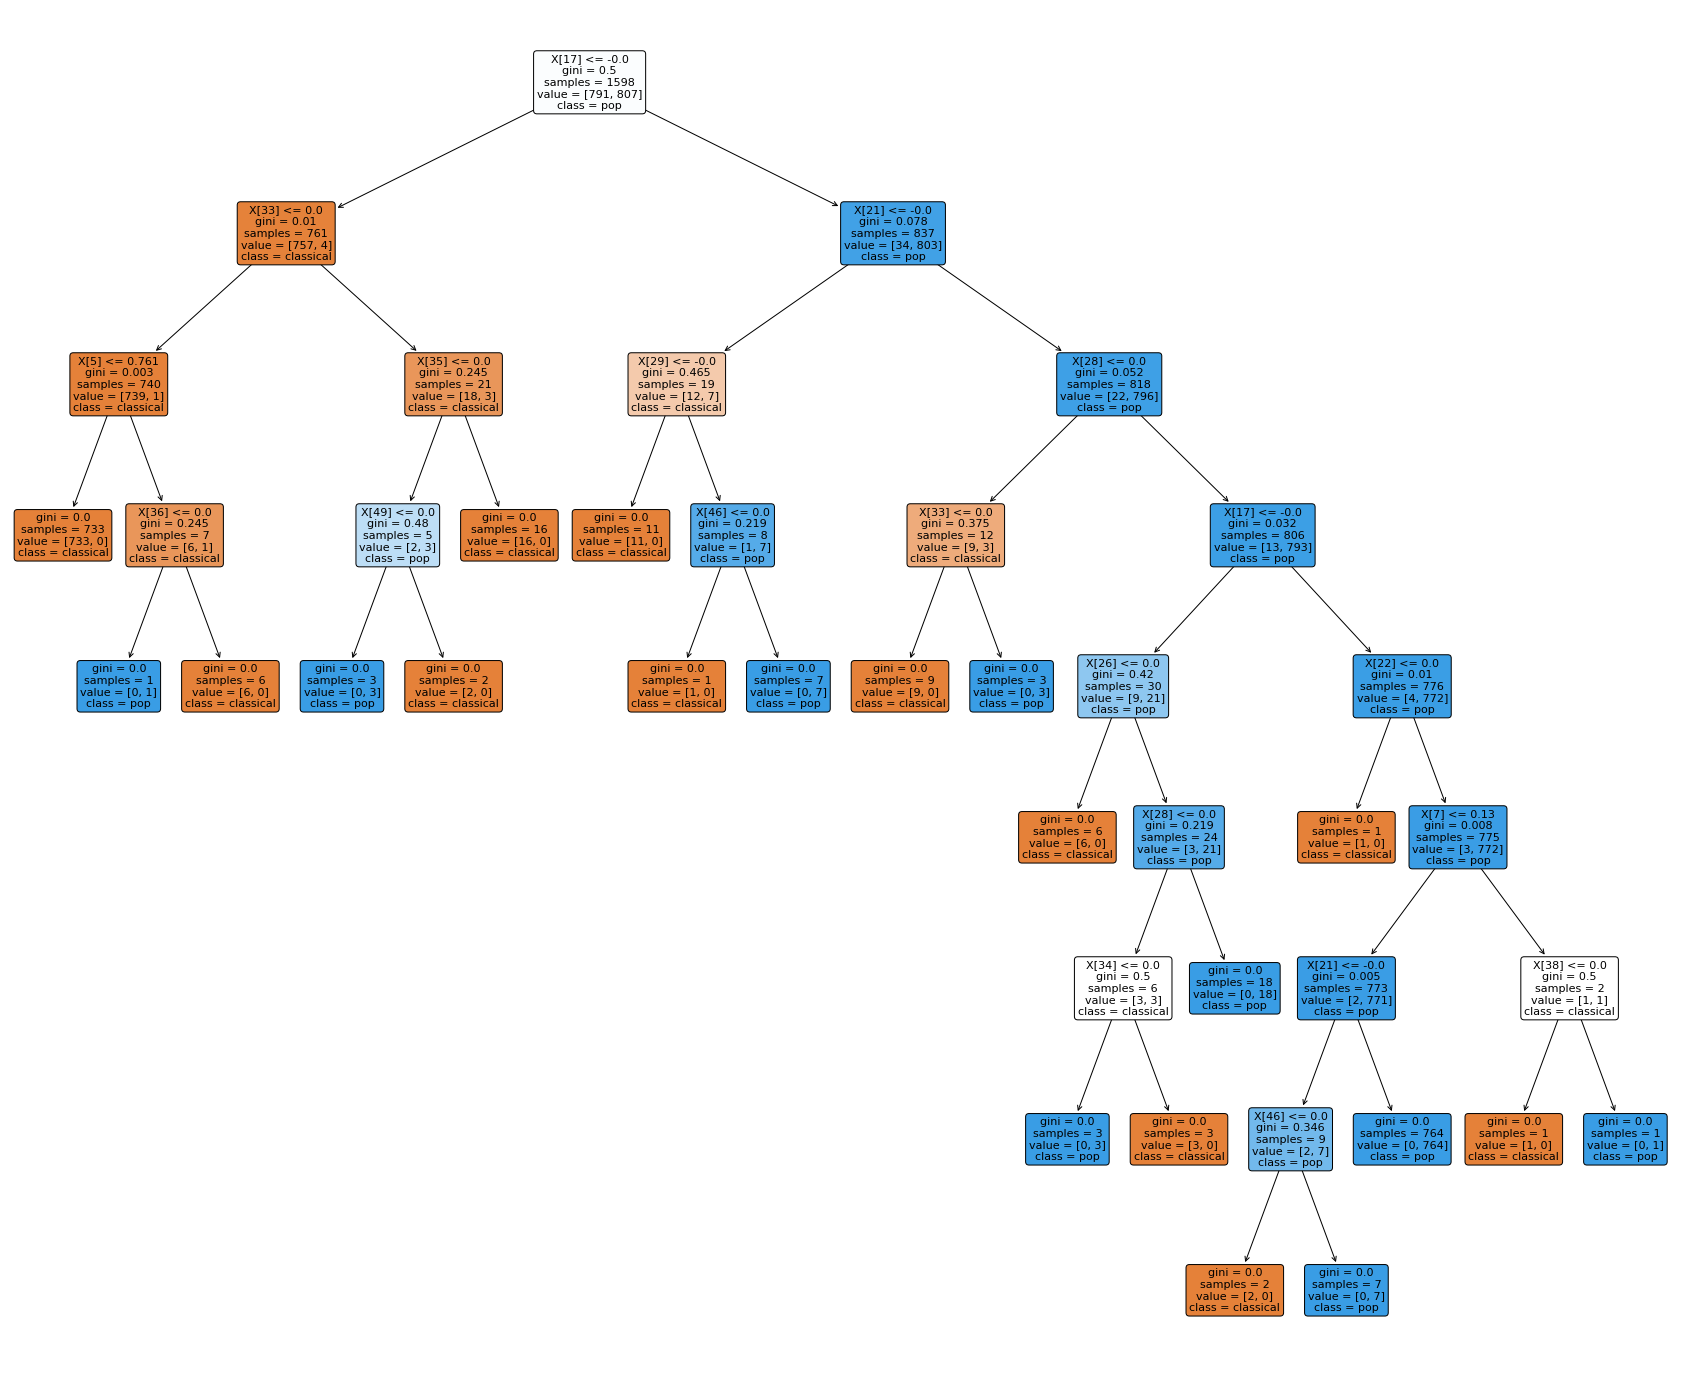

In [ ]:
# Plot the decision tree
fig = plt.figure(figsize=(30,25))
_ = tree.plot_tree(decision_tree, filled=True, class_names=["classical", "pop"], rounded=True)

In [ ]:
# Evaluate the decision tree classifier and print metrics
cm, acc, p, r, f1, cr = evaluate_model(decision_tree, X_test, y_test)
print(f"Confusion Matrix:\n{cm}\nAccuracy: {acc}, Precision: {p}, Recall: {r}, F1-score: {f1}\nClassification Report:\n{cr}")

Confusion Matrix:
[[202   5]
 [  5 188]]
Accuracy: 0.975, Precision: 0.9740932642487047, Recall: 0.9740932642487047, F1-score: 0.9740932642487047
Classification Report:
              precision    recall  f1-score   support

   classical       0.98      0.98      0.98       207
         pop       0.97      0.97      0.97       193

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



Here, we see that the default sklearn Decision Tree Classifier performs very well on the testing set across all metrics. There is a relatively small number of false positives and false negatives (5 each) in comparison to the true positives and true negatives, and so the precision, recall, and F1-score metrics are all high. 390/400 examples are correctly classified, so the accuracy is 97.5%.

### Compare Decision Tree Classifiers with Varying Split Criteria, Max Depth, and Max Features

Next, we train 36 sklearn Decision Tree Classifiers with varying combinations of split criteria, maximum depth, and maximum number of features per split.
The split criteria that we consider are Gini index and information gain.
The maximum tree depths that we consider are 1, 2, 5, 10, 100, and None (expand until "all leaves are pure or until all leaves contain less than two samples").
The maximum number of features per split that we consider are 'sqrt' (square root of number of features), 'log2' (log base 2 of number of features), and None (total number of features). We compare these classifiers on the accuracy metric since the data is balanced, and, in terms of interpretation, false positives (i.e. labeling a "classical" song as "pop") and false negatives (i.e. labeling a "pop" song as "classical") are equivalently harmful. Out of the metrics: accuracy, precision, recall, and F1-score, accuracy takes into account the number of correct predictions on the negative class ("classical"), and is the easiest to interpret. 

In [ ]:
# Run parameter varying experiments
result = vary_parameters(X_train, y_train, X_test, y_test)

In [ ]:
# Show resulting dictionary of (Split criterion, Max depth, Max features): Accuracy score
# for each combination of parameters
result

{('gini', 1, 'sqrt'): 0.8925,
 ('gini', 1, 'log2'): 0.8925,
 ('gini', 1, None): 0.9725,
 ('gini', 2, 'sqrt'): 0.9275,
 ('gini', 2, 'log2'): 0.9425,
 ('gini', 2, None): 0.97,
 ('gini', 5, 'sqrt'): 0.9625,
 ('gini', 5, 'log2'): 0.9725,
 ('gini', 5, None): 0.9825,
 ('gini', 10, 'sqrt'): 0.96,
 ('gini', 10, 'log2'): 0.9725,
 ('gini', 10, None): 0.975,
 ('gini', 100, 'sqrt'): 0.97,
 ('gini', 100, 'log2'): 0.97,
 ('gini', 100, None): 0.975,
 ('gini', None, 'sqrt'): 0.97,
 ('gini', None, 'log2'): 0.97,
 ('gini', None, None): 0.975,
 ('entropy', 1, 'sqrt'): 0.8925,
 ('entropy', 1, 'log2'): 0.8925,
 ('entropy', 1, None): 0.9725,
 ('entropy', 2, 'sqrt'): 0.9325,
 ('entropy', 2, 'log2'): 0.9425,
 ('entropy', 2, None): 0.9725,
 ('entropy', 5, 'sqrt'): 0.9675,
 ('entropy', 5, 'log2'): 0.965,
 ('entropy', 5, None): 0.9775,
 ('entropy', 10, 'sqrt'): 0.9775,
 ('entropy', 10, 'log2'): 0.955,
 ('entropy', 10, None): 0.9775,
 ('entropy', 100, 'sqrt'): 0.9775,
 ('entropy', 100, 'log2'): 0.97,
 ('entropy',

Below, we summarize the results of our parameter-varying experiments in tables.

#### Split criterion: Gini index, Metric: Accuracy score
Best score in row is **bold**, best score in column is *italic*, best score in table is []

|  | Max Depth | 1 | 2 | 5 | 10 | 100 | None |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|**Max Features**|
|$\sqrt{n}$||0.8925|0.9275|0.9625|0.9600|**0.9700**|**0.9700**
|$\log_2{n}$||0.8925|0.9425|**0.9725**|**0.9725**|0.9700|0.9700
|**None**||*0.9725*|*0.9700*|[***0.9825***]|*0.9750*|*0.9750*|*0.9750*

#### Split criterion: Information gain, Metric: Accuracy score
Best score in row is **bold**, best score in column is *italic*, best score in table is []

|  | Max Depth | 1 | 2 | 5 | 10 | 100 | None |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|**Max Features**|
|$\sqrt{n}$||0.8925|0.9325|0.9675|[***0.9775***]|[***0.9775***]|[***0.9775***]
|$\log_2{n}$||0.8925|0.9425|0.9650|0.9550|**0.9700**|**0.9700**
|**None**||*0.9725*|*0.9725*|[***0.9775***]|[***0.9775***]|[***0.9775***]|[***0.9775***]

Initially, we note that for either split criteria, and for any fixed maximum depth, the highest accuracy scores are achieved when the maximum number of features per split is None, that is, all features are considered on each split. 

For the Gini index split criterion, for any fixed maximum depth, a higher max features achieved higher accuracy scores, with small max depths and smaller max features achieving the lowest scores (0.8925). For max features 'sqrt', increasing the max depth increased the accuracy score, but when considering max features 'log2' and None, increasing the max depth no longer always increase the accuracy score. Overall, the highest accuracy score, 0.9825, is higher than the score achieved by the default sklearn Decision Tree Classifier, and is achieved when max depth is 5 and max features is None. For this dataset, when considering all features for each split, limiting the max depth helps prevent overfitting.

For the information gain split criterion, for any fixed max features, a higher max depth achieved higher accuracy scores, with small max depths and smaller max features achieving the lowest scores (0.8925). For this criterion, the overall highest accuracy score, 0.9775, is higher than the score achieved by the default sklearn Decision Tree Classifier, and is achieved for (Max depth, Max features) pairs (10, 'sqrt'), (100, 'sqrt'), (None, 'sqrt'), (5, 'None'), (10, None), (100, None), and (None, None).

As a result, we note that the overall trends are similar for the Gini index and information gain split criteria. Generally, considering a greater number of features at each split improved the accuracy. For some settings of split criteria and maximum features, a higher depth improved accuracy, whereas for others, a higher depth decreased accuracy. 

---
## **Task 2: Bagging and Boosting for Binary Music Genre Classification**

In this section, we will use sklearn to implement bagging (extra-trees classifier) and boosting (gradient boosting classifier) ensemble methods for binary music genre classification ("classical" vs "pop"). We will use k-fold cross validation to compare the effectiveness of the two models.


In [ ]:
# Define a sklearn Extra-Trees Classifier (bagging) with 100 estimators
bagging = ExtraTreesClassifier(n_estimators=100)

In [ ]:
# Run 10-fold cross validation of the Extra-Trees Classifier on the training dataset, repeated 3 times
# Print the mean and standard deviation of the cross validation accuracy scores 
# (calculated across the models trained on 90% of the training data and tested on the remaining 10%)
cross_validation = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
cross_validation_scores = cross_val_score(bagging, X_train, y_train, scoring='accuracy', cv=cross_validation, n_jobs=-1, error_score='raise')
print(f"Accuracy score: Mean: {np.mean(cross_validation_scores)}, Standard Deviation: {np.std(cross_validation_scores)}")

Accuracy score: Mean: 0.9849724842767298, Standard Deviation: 0.009530938013180352


In [ ]:
# Fit bagging model over entire training dataset and evaluate on testing dataset
bagging.fit(X_train, y_train)
cm, acc, p, r, f1, cr = evaluate_model(bagging, X_test, y_test)
print(f"Confusion Matrix:\n{cm}\nAccuracy: {acc}, Precision: {p}, Recall: {r}, F1-score: {f1}\nClassification Report:\n{cr}")
# Accuracy is 98.5% (394/400)

Confusion Matrix:
[[201   6]
 [  0 193]]
Accuracy: 0.985, Precision: 0.9698492462311558, Recall: 1.0, F1-score: 0.9846938775510203
Classification Report:
              precision    recall  f1-score   support

   classical       1.00      0.97      0.99       207
         pop       0.97      1.00      0.98       193

    accuracy                           0.98       400
   macro avg       0.98      0.99      0.98       400
weighted avg       0.99      0.98      0.99       400



In [ ]:
# Define a sklearn Gradient Boosting Classifier (boosting) with 100 boosting stages
boosting = GradientBoostingClassifier(n_estimators=100, random_state=42)

In [ ]:
# Run 10-fold cross validation of the Gradient Boosting Classifier on the training dataset, repeated 3 times
# Print the mean and standard deviation of the cross validation accuracy scores 
# (calculated across the models trained on 90% of the training data and tested on the remaining 10%)
cross_validation_scores = cross_val_score(boosting, X_train, y_train, scoring='accuracy', cv=cross_validation, n_jobs=-1, error_score='raise')
print(f"Accuracy: Mean: {np.mean(cross_validation_scores)}, Standard Deviation: {np.std(cross_validation_scores)}")

Accuracy: Mean: 0.9837185534591195, Standard Deviation: 0.00953009631552227


In [ ]:
# Fit boosting model over entire training dataset and evaluate on testing dataset
boosting.fit(X_train, y_train)
cm, acc, p, r, f1, cr = evaluate_model(boosting, X_test, y_test)
print(f"Confusion Matrix:\n{cm}\nAccuracy: {acc}, Precision: {p}, Recall: {r}, F1-score: {f1}\nClassification Report:\n{cr}")
# Accuracy is % (395/400)

Confusion Matrix:
[[202   5]
 [  0 193]]
Accuracy: 0.9875, Precision: 0.9747474747474747, Recall: 1.0, F1-score: 0.9872122762148338
Classification Report:
              precision    recall  f1-score   support

   classical       1.00      0.98      0.99       207
         pop       0.97      1.00      0.99       193

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



In this section, we ran 10-fold cross validation, repeated 3 times, for two models: a sklearn Extra-Trees Classifier with 100 estimators (bagging), and a sklearn Gradient Boosting Classifier with 100 boosting stages. We note that this cross validation takes ~5 seconds to run for the bagging model, and ~55 seconds to run for the boosting model, suggesting that the 100 boosting stages are more powerful/require longer to train than the 100 estimators. The mean cross validation accuracy score for the extra-trees classifier is 0.9850, which is slightly higher than the score for the gradient boosting classifier 0.9837. When the models are fit on the entire training data and evaluated on the testing data, the extra-trees classifier falsely classifies one more "classical" example as "pop", compared to the gradient boosting classifier, although both achieve a very high accuracy on the testing set. 

---
## **Task 3: Comparing Decision Tree Classifier, Bagging, and Boosting**

In this section, we will compare the effectiveness of the base decision tree classifier, the extra-trees classifier (bagging), and the gradient boosting classifier (boosting) models implemented above. 


#### Metric: Accuracy score

Initially, we compare the effectiveness of four models: the default sklearn Decision Tree Classifier, the sklearn Decision Tree Classifier with max depth 5, the sklearn Extra-Trees Classifier, and the sklearn Gradient Boosting Classifier, all trained on the full training dataset, on the test set, with the accuracy metric. The accuracy metric is defined as the number of correct predictions divided by the total number of examples. In the binary classification case with positive and negative classes, this is equal to the sum of the true positives and true negatives divided by the total number of examples. We choose accuracy over other metrics for this problem because the data is balanced, false positives (i.e. labeling a "classical" song as "pop") and false negatives (i.e. labeling a "pop" song as "classical") are equivalently harmful, and accuracy is the easiest to interpret. Precision is a good metric to consider when false positives are particularly harmful (for example, when classifying spam emails, we do not want to classify non-spam emails as spam). On the other hand, recall is a good metric to consider when false negatives are particularly harmful (for example, in medical diagnosis, missing a positive case is harmful since treatment may not be given to someone who needs it). F1-score, which is the harmonic mean of precision and recall balance the two, but is advantageous when data is imbalanced and is generally harder to interpret than accuracy. In the task of binary music classification, there is no notion of a difference between errors on the "positive" class ("pop") and the "negative" class ("classical"), that is, we do not care more if a "pop" examples is misclassified as "classical" as opposed to a "classical" example being misclassified as "pop". Additionally, the data is almost exactly balanced, in both training and test sets. As a result, we use accuracy are our metric for comparison. The compared scores are shown below.

|  | Accuracy | 
|:---:|:---:|
|**Default sklearn Decision Tree Classifier**|0.9750
|**Best sklearn Decision Tree Classifier**|0.9825
|**sklearn Extra-Trees Classifier**|0.9850
|**sklearn Gradient Boosting Classifier**|**0.9875**

We see that all four classifiers perform very well on the test set. The bagging and boosting methods provide minor improvements over the single decision tree classifiers, with the Gradient Boosting Classifier achieving the highest performance.

#### Other metrics

Lastly, we take a look at the confusion matrices for the four classifiers and consider what our conclusions would be if we used precision, recall, or F1-score as our metrics.

| Default Decision Tree | Predicted "Classical" | Predicted "Pop" | 
|:---:|:---:|:---:|
|**True "Classical"**| 202 | 5
|**True "Pop"**| 5 | 188

| Best Decision Tree | Predicted "Classical" | Predicted "Pop" | 
|:---:|:---:|:---:|
|**True "Classical"**| 202 | 5
|**True "Pop"**| 2 | 191

| Extra-Trees Classifier | Predicted "Classical" | Predicted "Pop" | 
|:---:|:---:|:---:|
|**True "Classical"**| 201 | 6
|**True "Pop"**| 0 | 193

| Gradient Boosting Classifier | Predicted "Classical" | Predicted "Pop" | 
|:---:|:---:|:---:|
|**True "Classical"**| 202 | 5
|**True "Pop"**| 0 | 193

|  | Precision | 
|:---:|:---:|
|**Default sklearn Decision Tree Classifier**| 0.9741
|**Best sklearn Decision Tree Classifier**| 0.9745
|**sklearn Extra-Trees Classifier**| 0.9698
|**sklearn Gradient Boosting Classifier**| **0.9747**

|  | Recall | 
|:---:|:---:|
|**Default sklearn Decision Tree Classifier**| 0.9741
|**Best sklearn Decision Tree Classifier**| 0.9896
|**sklearn Extra-Trees Classifier**| **1.0000**
|**sklearn Gradient Boosting Classifier**| **1.0000**

|  | F1-Score | 
|:---:|:---:|
|**Default sklearn Decision Tree Classifier**| 0.9741
|**Best sklearn Decision Tree Classifier**| 0.9820
|**sklearn Extra-Trees Classifier**| 0.9847
|**sklearn Gradient Boosting Classifier**| **0.9872**

When considering precision, the Gradient Boosting Classifier has the highest performance. However, the default and best decision tree classifiers have a higher performance than the Extra-Trees classifier since the Extra-Trees classifier misclassifies one more "classical" point as "pop.

When considering recall, both the Extra-Trees and Gradient Boosting Classifiers achieve a perfect score, as there are no false negatives (true "pop" predicted "classical").

When considering F1-score, we have a similar result to accuracy; the bagging and boosting methods provide minor improvements over the single decision tree classifiers, with the Gradient Boosting Classifier achieving the highest performance.

As a result, we see that choosing a different metric, in some cases, would impact our results for this binary music genre classification task.